In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
pd.options.mode.chained_assignment = None

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/TrabajoFinalSIE"

if os.path.exists(path):
    print("El archivo existe en la ruta especificada.")
else:
    print("Archivo no encontrado. Verifica la ruta.")

El archivo existe en la ruta especificada.


# CARGA DE DATOS

In [4]:
orders = pd.read_csv(f"{path}/orders.csv")
customers = pd.read_csv(f"{path}/customers.csv")
geolocation = pd.read_csv(f"{path}/geolocation.csv")
order_items = pd.read_csv(f"{path}/order_items.csv")
payments = pd.read_csv(f"{path}/payments.csv")
products = pd.read_csv(f"{path}/products.csv")  #product category
sellers = pd.read_csv(f"{path}/sellers.csv")

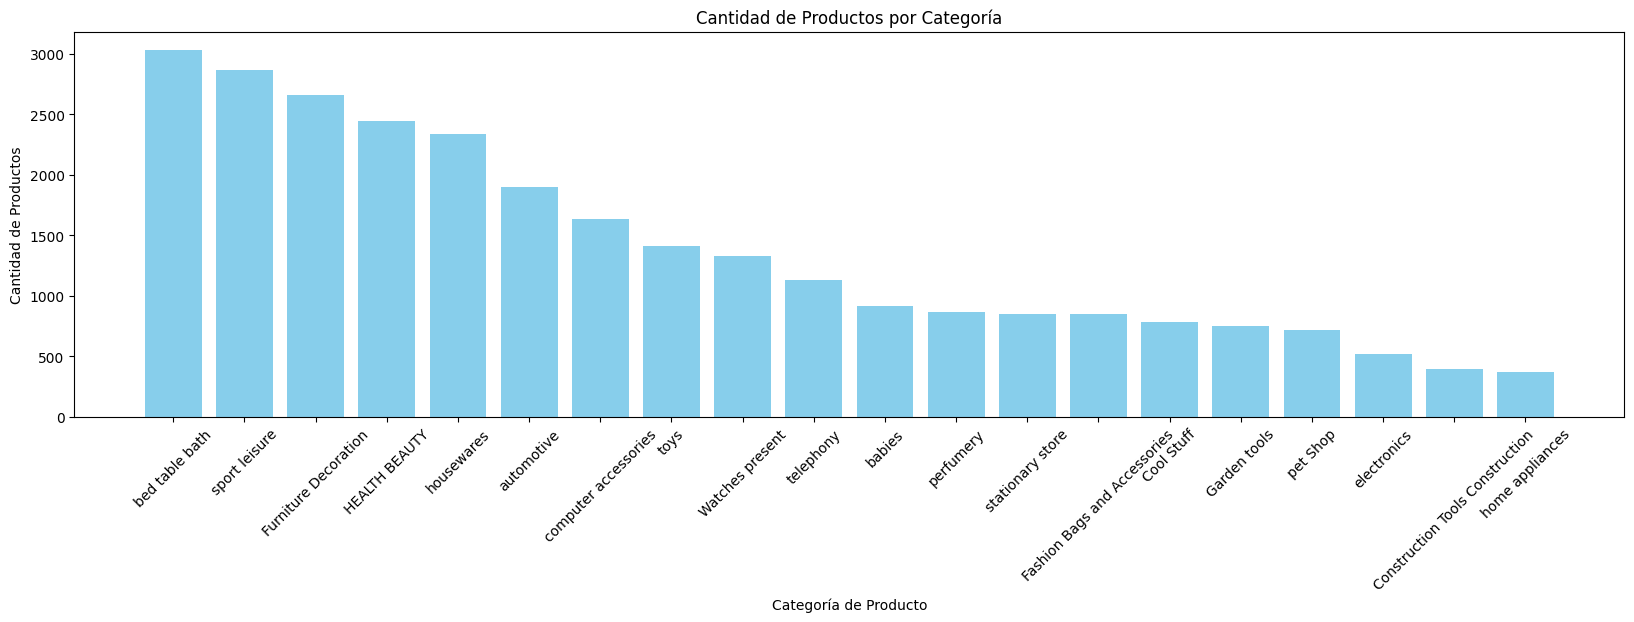

In [14]:
#EDA
category_counts = products['product category'].value_counts().head(20)

# Crear el gráfico de barras
plt.figure(figsize=(20, 5))
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Categoría de Producto')
plt.ylabel('Cantidad de Productos')
plt.title('Cantidad de Productos por Categoría')
plt.xticks(rotation=45)
plt.show()

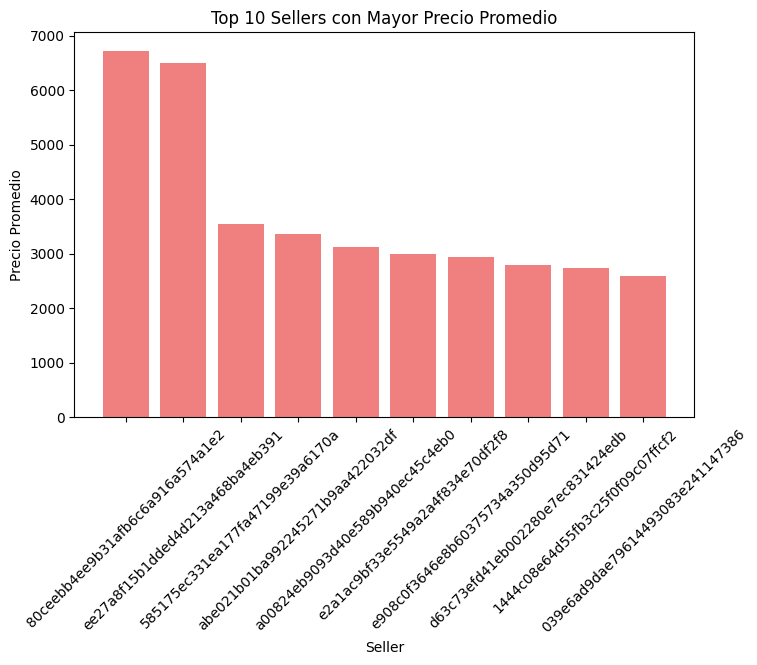

In [20]:
#Precio promedio de productos por seller
avg_price_per_seller = order_items.groupby('seller_id')['price'].mean().nlargest(10)

plt.figure(figsize=(8, 5))
plt.bar(avg_price_per_seller.index, avg_price_per_seller.values, color='lightcoral')
plt.xlabel('Seller')
plt.ylabel('Precio Promedio')
plt.title('Top 10 Sellers con Mayor Precio Promedio')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Eliminar nulos
orders = orders.dropna()
customers = customers.dropna()
geolocation = geolocation.dropna()
order_items = order_items.dropna()
payments = payments.dropna()
products = products.dropna()
sellers = sellers.dropna()


In [ ]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [ ]:
#Existe una unica orden por cliente, asi que se puede extrapolar ordenes a clientes de forma lineal
orders["customer_id"].nunique() == orders["order_id"].nunique()

True

# SEGMENTACION DE ORDENES

El primer analisis tiene como objetivo clusterizar las ordenes (de clientes unicos) segun metricas relacionadas a los productos, pago, flete y tiempo de envio.
Se usaran las variables:
1. Numero de productos (NProds)
2. Gasto total de la orden (Monto)
3. Monto promedio de orden / productos (Promedio)
4. Cuotas de pago (Cuotas)
5. Flete (Envio)
6. Tiempo de envio real (llegada - pedido) (Tiempo de envio)

In [ ]:
#Tomamos algunas variables directamente
orders_summary = order_items.groupby("order_id").agg(
    num_products=("product_id", "count"),
    total_spent=("price", "sum"),
    total_envio=("freight_value", "sum")
).reset_index()

orders_summary = orders_summary.sort_values("num_products", ascending = False)
orders_summary


,order_id,num_products,total_spent,total_envio
50137,8272b63d03f5f79c56e9e4120aec44ef,21,31.80,164.37
10459,1b15974a0141d54e36626dca3fdc731a,20,2000.00,202.40
65715,ab14fdcfbe524636d65ee38360e22ce8,20,1974.00,288.80
60941,9ef13efd6949e4573a18964dd1bbe7f5,15,765.00,18.00
25583,428a2f660dc84138d969ccd69a0ab6d5,15,982.35,243.30
...,...,...,...,...
34640,5a0911d70c1f85d3bed0df1bf693a6dd,1,59.00,51.13
34639,5a082b558a3798d3e36d93bfa8ca1eae,1,9.00,15.23
34637,5a07264682e0b8fbb3f166edbbffc6e8,1,19.90,19.32
34636,5a071192a28951b76774e5a760c8c9b7,1,899.00,106.43


### **CALCULO DE VARIABLES UTILES**

In [ ]:
#Creación de tabla para segmentar (cada registro es una orden)

seg = pd.DataFrame()
#Variable 1: Cantidad de productos por orden
seg["order_id"] = orders["order_id"].unique()
#Variable 2 y 3: Suma de gastos por producto y envios
seg = seg.merge(orders_summary[["order_id","num_products","total_spent","total_envio"]], on="order_id", how="left")

#Variable 4: Agregar el numero de cuotas desde payments.csv
seg = seg.merge(payments[["order_id","payment_installments"]], on="order_id", how="left")
seg = seg.dropna()
seg = seg.rename(columns={
    "order_id": "Pedido",
    "num_products": "Nprod",
    "total_spent": "Monto",
    "total_envio": "Envio",
    "payment_installments" : "Cuotas"
})

#Variable 5: Promedio de precio por producto
seg["Promedio"] = seg["Monto"] / seg["Nprod"]

#Variable 6: Tiempo de entrega real
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
seg["TiempoEntrega"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days

#Eliminamos valores nulos de los plazos de entrega
seg = seg.dropna()

seg.isna().sum()



,0
Pedido,0
Nprod,0
Monto,0
Envio,0
Cuotas,0
Promedio,0
TiempoEntrega,0


### **DESARROLLO DEL ALGORITMO K MEANS**

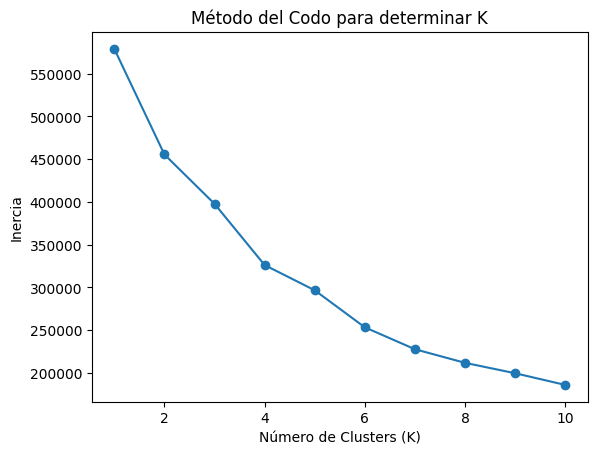

In [ ]:
#Se desarrolla el algoritmo K Means

#Normalizar datos
scaler = StandardScaler()

X = scaler.fit_transform(seg[["Nprod", "Monto", "Envio", "Cuotas", "Promedio", "TiempoEntrega"]])

#Sacar el K

inertia = []
K_range = range(1,11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficamos la inercia para ver el "codo"
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo para determinar K")
plt.show()

#Se aprecia que a partir de 4-5 K la inercia baja y se vuelve un desplazamiento mas gradual. Entonces K = 5.

In [ ]:
k_optimo = 5
kmeans = KMeans(n_clusters = k_optimo, random_state = 42)
seg["Cluster"] = kmeans.fit_predict(X)

seg["Cluster"].value_counts()

,count
Cluster,
0,69395
1,16082
3,8145
4,1796
2,1042


### **ANALISIS DE CLUSTER POR VARIABLE**

In [ ]:
#Agrupamos por cluster y definimos metricas relevantes: Media, Mediana, Desv, Percentiles
seg_cluster = seg.groupby("Cluster").agg({
    "Nprod": ["mean", "median", "std", "min", "max"],
    "Monto": ["mean", "median", "std", "min", "max"],
    "Envio": ["mean", "median", "std", "min", "max"],
    "Cuotas": ["mean", "median", "std", "min", "max"],
    "Promedio": ["mean", "median", "std", "min", "max"],
    "TiempoEntrega": ["mean", "median", "std", "min", "max"]})

seg_cluster

Nprod                                 Monto                      \
             mean median       std min max         mean  median         std   
Cluster                                                                       
0        1.000000    1.0  0.000000   1   1    85.589010   65.90   70.186348   
1        1.058077    1.0  0.235487   1   3   211.629042  164.90  150.423849   
2        4.518234    4.0  1.805678   1  21   398.526593  295.00  357.730484   
3        2.096378    2.0  0.488490   1   4   158.178895  119.80  124.833998   
4        1.067372    1.0  0.347573   1   8  1205.112589  998.95  684.960799   

                           ...     Promedio                                   \
            min       max  ...         mean   median         std         min   
Cluster                    ...                                                 
0          0.85    629.99  ...    85.589010   65.900   70.186348    0.850000   
1          9.99    938.00  ...   205.015307  159.000  148.446458    9.990000   
2         17.50   3099.75  ...   105.817822   66.204  114.330046    1.514286   
3          6.98   1049.70  ...    81.986088   59.800   75.374589    3.060000   
4        550.00  13440.00  ...  1149.650058  969.990  579.705977  429.000000   

                 TiempoEntrega                                
             max          mean median        std  min    max  
Cluster                                                       
0         629.99     12.112674   10.0   9.531547  0.0  209.0  
1         750.00     11.978610   10.0   9.296793  0.0  173.0  
2         979.00     11.882917   10.0   9.197675  1.0  143.0  
3         599.90     12.200614   10.0  10.314363  0.0  194.0  
4        6735.00     12.006682   10.0   9.150366  1.0   83.0  

[5 rows x 30 columns]

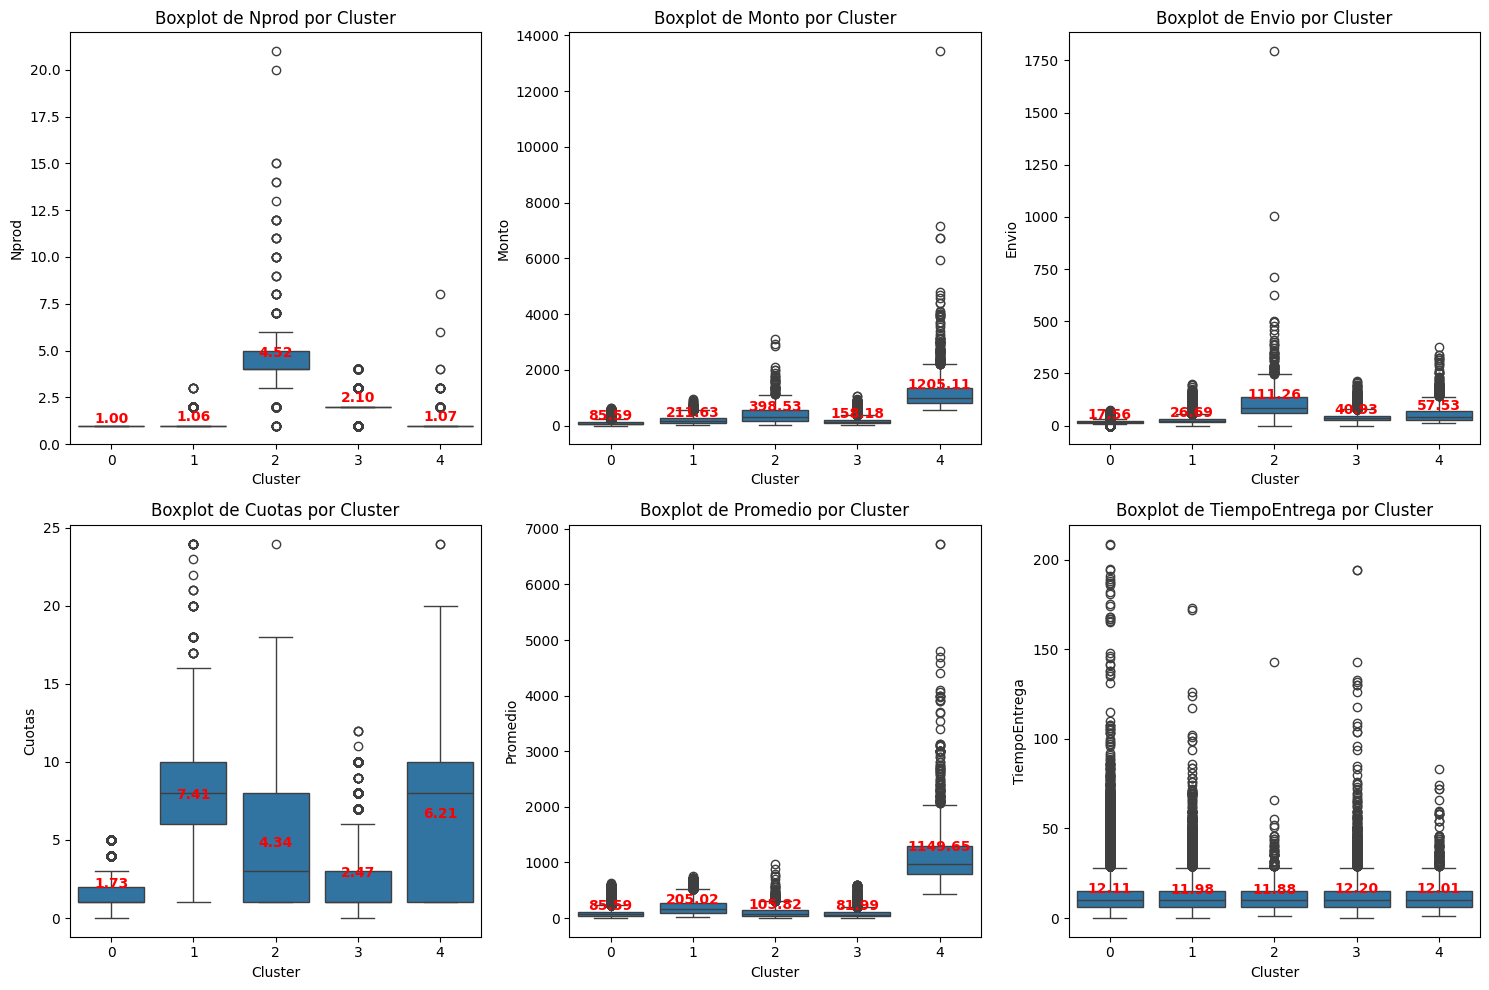

In [ ]:
# Lista de variables a graficar
variables = ["Nprod", "Monto", "Envio", "Cuotas", "Promedio", "TiempoEntrega"]

# Crear subgráficos
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Para iterar sobre ellos fácilmente

for i, var in enumerate(variables):
    ax = axes[i]
    sns.boxplot(x="Cluster", y=var, data=seg, ax=ax)

    # Calcular medias y agregarlas como texto
    means = seg.groupby("Cluster")[var].mean()
    for cluster in means.index:
        ax.text(cluster, means[cluster], f"{means[cluster]:.2f}",
                ha="center", va="bottom", fontsize=10, color="red", fontweight="bold")

    ax.set_title(f"Boxplot de {var} por Cluster")

plt.tight_layout()
plt.show()

A partir de este boxplot, se pueden clasificar a los clusters de esta forma:

Cluster 0: **Clientes monoproducto,** compran generalmente a una u dos cuotas productos no tan costosos.

Cluster 1: Clientes monoproducto en su mayoria, pero que suelen comprar productos algo mas costosos y a muchas cuotas. **Se presupone poca capacidad adquisitiva.**

Cluster 2: **Clientes multiproducto, suelen llevar varios productos en general** y a un precio moderado. Su costo de envio es mayor debido a la cantidad de productos.

Cluster 3: Clientes multiproducto (pocos productos) pero que suelen comprar cosas muy baratas. **Son clientes que agarran ofertas probablemente.**

Cluster 4: Clientes Monoproducto, pero piden cosas muy costosas y a muchas cuotas. Pueden ser clientes muy adinerados y financieramente inteligentes o deudores con poca capacidad de pago.

Otras conclusiones relevantes:


*   El flete no se calcula en base a la distancia, sino solo a los productos. Se puede hacer un analisis para saber si se toma en cuenta peso, tamano u otra metrica.
*   El tiempo de envio tampoco esta relacionado a los envios en si, parece que es algo mas aleatorio




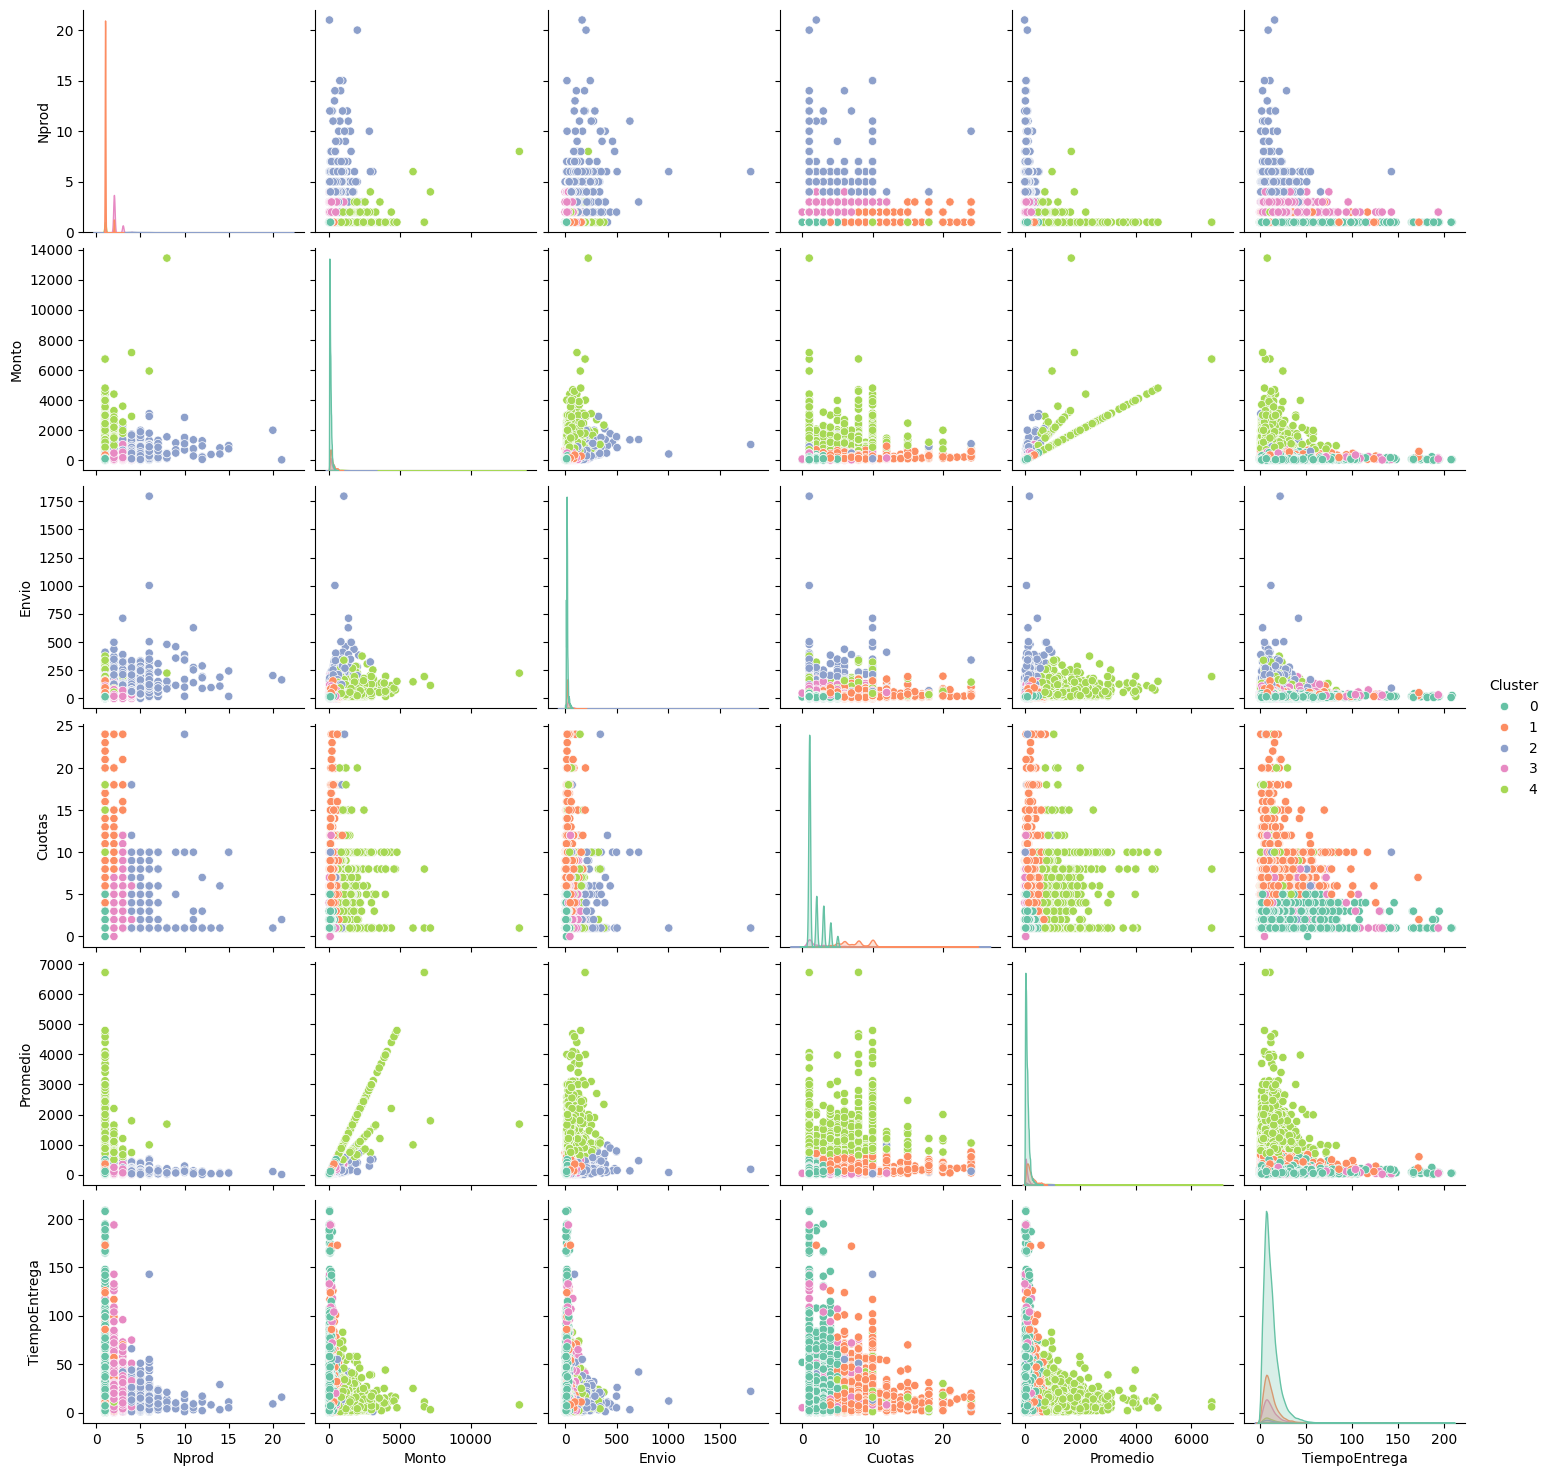

In [ ]:
#Obtenemos diferentes graficos para analizar por par de variables
sns.pairplot(seg, hue="Cluster", palette="Set2")
plt.show()

# PREDICCION DEL TIEMPO DE LLEGADA


El siguiente analisis tiene como objetivo brindar una mejor experiencia de usuario a cada cliente. Por ello, se elaborara un modelo de prediccion haciendo uso del algoritmo Random Forest para predecir un tiempo de llegada a cada orden segun algunas variables de interes. Estas son:

1.   Desviación del Viaje (Ajuste entre el tiempo real y estimado).
2.   Tiempo Total del Proceso (Desde la compra hasta la entrega).
3.   Desviación del Viaje (Ajuste entre el tiempo real y estimado).
4.   Desviación Media (Promedio de la desviación).
5.   Factor de Eficiencia Logística (Relación distancia-tiempo).
6.   Diferencia con el Curier (Retraso en la entrega al courier).
7.   Distancia en km (Entre vendedor y cliente).
8.   Tiempo de Viaje Estimado (Tiempo esperado de entrega).
9.   Distancia-Desviación (Relación distancia-tiempo estimado).


La variable a predecir sera Y: Tiempo de llegada (que se calcula restando la hora real de llegada - la hora en la que el pedido fue hecho)

In [ ]:
geolocation = geolocation.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "mean",  # Puedes usar mean, first o median según convenga
    "geolocation_lng": "mean"
}).reset_index()
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733
...,...,...,...
19010,99960,-27.953722,-52.025511
19011,99965,-28.183372,-52.039850
19012,99970,-28.343766,-51.874689
19013,99980,-28.389129,-51.843836


In [ ]:
#Creamos la matriz de datos
tmp = pd.DataFrame()
tmp["order_id"] = orders["order_id"].unique()

orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"]) #Hora de aprobacion
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"]) #Hora de compra
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"]) #Hora de arribo del transportista
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"]) #Hora estimada de llegada

tmp = tmp.merge(orders[["order_id","order_approved_at", "order_delivered_carrier_date", "order_estimated_delivery_date", "order_purchase_timestamp" ]], on="order_id", how="left")
tmp = tmp.dropna()
tmp = tmp.rename(columns={
    "order_approved_at": "HoraAprobacion",
    "order_delivered_carrier_date": "HoraCurier",
    "order_estimated_delivery_date" : "HoraEstimada",
    "order_purchase_timestamp" : "HoraCompra"
})

#Pasar de forma intermedia a las tablas
order_items = order_items.merge(sellers[["seller_id", "seller_zip_code_prefix"]], on= "seller_id", how="left")
orders = orders.merge(customers[["customer_id", "customer_zip_code_prefix"]], on="customer_id", how="left")

#Renombramos
order_items = order_items.rename(columns={"seller_zip_code_prefix": "geolocation_zip_code_prefix"})
orders = orders.rename(columns={"customer_zip_code_prefix": "geolocation_zip_code_prefix"})

#Pasamos a las tablas
order_items = order_items.merge(geolocation[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]], on="geolocation_zip_code_prefix", how="left")
orders = orders.merge(geolocation[["geolocation_zip_code_prefix", "geolocation_lat", "geolocation_lng"]], on="geolocation_zip_code_prefix", how="left")

In [ ]:
order_items = order_items.dropna()
orders = orders.dropna()
order_items= order_items.drop_duplicates(subset=["order_id"], keep="first")
orders= orders.drop_duplicates(subset=["order_id"], keep="first")

In [ ]:
#Pasar a la tabla de entrenamiento
tmp = tmp.merge(order_items[["order_id", "geolocation_lat", "geolocation_lng"]], on="order_id", how="left")
tmp = tmp.merge(orders[["order_id", "geolocation_lat", "geolocation_lng"]], on="order_id", how="left")


#Variable Y: Tiempo de llegada
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
tmp["TiempoEntrega"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days

tmp = tmp.dropna()

In [ ]:
tmp = tmp.rename(columns={
    "geolocation_lat_x": "LatitudSeller",
    "geolocation_lng_x": "LongitudSeller",
    "geolocation_lat_y" : "LatitudCustomer",
    "geolocation_lng_y" : "LongitudCustomer"
})

In [ ]:
print(tmp.columns)

Index(['order_id', 'HoraAprobacion', 'HoraCurier', 'HoraEstimada',
       'HoraCompra', 'LatitudSeller', 'LongitudSeller', 'LatitudCustomer',
       'LongitudCustomer', 'TiempoEntrega'],
      dtype='object')


### **CODIFICACION DE VARIABLES**

In [ ]:
#Procesamiento para las fechas
tmp["Diff_Curier"] = (tmp["HoraCurier"] - tmp["HoraCompra"]).dt.total_seconds() / 3600
tmp["Diff_Estimado"] = (tmp["HoraEstimada"] - tmp["HoraCompra"]).dt.total_seconds() / 86400
tmp["Tiempo_Total_Proceso"] = tmp["Diff_Curier"] + tmp["Diff_Estimado"]

In [ ]:
tmp.drop(columns=["HoraAprobacion", "HoraCurier", "HoraEstimada", "HoraCompra"], inplace=True)

In [ ]:
#Calculo de la distancia
# Radio de la Tierra en km
R = 6371

# Convertir grados a radianes
tmp["LatitudSeller_rad"] = np.radians(tmp["LatitudSeller"])
tmp["LongitudSeller_rad"] = np.radians(tmp["LongitudSeller"])
tmp["LatitudCustomer_rad"] = np.radians(tmp["LatitudCustomer"])
tmp["LongitudCustomer_rad"] = np.radians(tmp["LongitudCustomer"])

# Diferencias de coordenadas
delta_lat = tmp["LatitudCustomer_rad"] - tmp["LatitudSeller_rad"]
delta_lon = tmp["LongitudCustomer_rad"] - tmp["LongitudSeller_rad"]

# Aplicar fórmula de Haversine
a = np.sin(delta_lat / 2) ** 2 + np.cos(tmp["LatitudSeller_rad"]) * np.cos(tmp["LatitudCustomer_rad"]) * np.sin(delta_lon / 2) ** 2
c = 2 * np.arcsin(np.sqrt(a))
tmp["Distancia_km"] = R * c  # Distancia en km

# Suponiendo una velocidad promedio de 40 km/h (ajustable según datos históricos)
velocidad_promedio_kmh = 40

# Calcular el tiempo estimado de viaje en horas
tmp["Tiempo_Viaje_Estimado"] = tmp["Distancia_km"] / velocidad_promedio_kmh

# Convertir a minutos para mayor precisión
tmp["Tiempo_Viaje_Estimado"] *= 60
tmp["Desviacion_Viaje"] = (tmp["TiempoEntrega"] - tmp["Diff_Curier"]) - tmp["Tiempo_Viaje_Estimado"] # Diferencia entre el tiempo real de entrega y el tiempo estimado del viaje
tmp["Factor_Eficiencia_Logistica"] = (tmp["Distancia_km"] / (tmp["Tiempo_Total_Proceso"] + 1e-6)) * (1 / (tmp["Desviacion_Viaje"] + 1e-6) )# Mide la eficiencia logística considerando la distancia recorrida
tmp["Desviacion_Real"] = (tmp["TiempoEntrega"] - tmp["Tiempo_Viaje_Estimado"]) - (tmp["Diff_Curier"] + tmp["Diff_Estimado"]) # Desviación real del tiempo de entrega
tmp["Desviacion_Media"] = (tmp["TiempoEntrega"] - tmp["Tiempo_Viaje_Estimado"]) / 2 # Promedio de la diferencia entre el tiempo real de entrega y el tiempo estimado.
tmp["Distancia_Desviacion"] = tmp["Distancia_km"] / (tmp["Tiempo_Viaje_Estimado"] + 1) # Relación entre la distancia recorrida y el tiempo estimado de viaje

# Eliminar columnas temporales de radianes
tmp.drop(columns=["LatitudSeller_rad", "LongitudSeller_rad", "LatitudCustomer_rad", "LongitudCustomer_rad"], inplace=True)

In [ ]:
tmp = tmp.drop_duplicates(subset=["order_id"], keep="first")
tmp.drop(columns=["LatitudSeller", "LongitudSeller", "LatitudCustomer", "LongitudCustomer","Diff_Estimado"], inplace=True)
tmp

,order_id,TiempoEntrega,Diff_Curier,Tiempo_Total_Proceso,Distancia_km,Tiempo_Viaje_Estimado,Desviacion_Viaje,Factor_Eficiencia_Logistica,Desviacion_Real,Desviacion_Media,Distancia_Desviacion
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,56.974167,72.518229,18.576110,27.864164,-76.838331,-0.003334,-92.382393,-9.932082,0.643570
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,41.823056,60.960822,851.495069,1277.242603,-1306.065658,-0.010695,-1325.203425,-632.121301,0.666145
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,5.186389,31.826100,514.410666,771.616000,-767.802388,-0.021051,-794.442099,-381.308000,0.665804
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,90.198056,116.386875,1822.226336,2733.339504,-2810.537560,-0.005571,-2836.726379,-1360.169752,0.666423
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,22.465278,34.577326,29.676625,44.514937,-64.980215,-0.013208,-77.092263,-21.257468,0.652019
...,...,...,...,...,...,...,...,...,...,...,...
96456,9c5dedf39a927c1b2549525ed64a053c,8.0,25.399444,43.986887,69.755064,104.632595,-122.032040,-0.012995,-140.619482,-48.316298,0.660355
96457,63943bddc261676b46f01ca7ac2f7bd8,22.0,34.395556,57.854606,474.120037,711.180055,-723.575610,-0.011326,-747.034661,-344.590027,0.665731
96458,83c1379a015df1e13d02aae0204711ab,24.0,30.095278,60.479502,967.847297,1451.770945,-1457.866223,-0.010977,-1488.250447,-713.885472,0.666208
96459,11c177c8e97725db2631073c19f07b62,17.0,90.110000,127.215243,370.404482,555.606723,-628.716723,-0.004631,-665.821966,-269.303362,0.665469


### **Entrenamiento del modelo**

In [ ]:
X = tmp.drop(columns=["TiempoEntrega", "order_id"]) # Variables predictoras
y = tmp["TiempoEntrega"]  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=15,
                           random_state=42,
                           min_samples_split=5,
                           min_samples_leaf=2,
                           n_jobs=-1,
                           max_features='sqrt',
                           )
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

lista = [mae, rmse]
lista

[3.9954679304219805, 6.870645235536149]

In [ ]:
r2_score(y_test, y_pred)

0.519702636618623

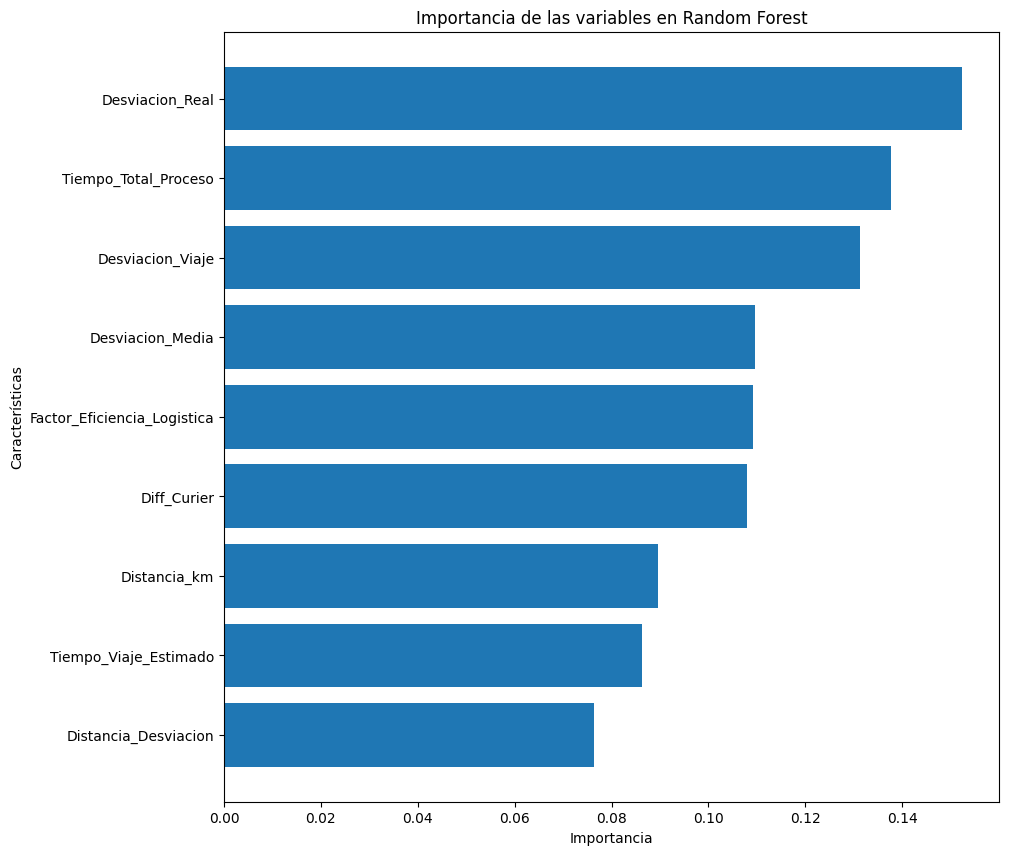

In [ ]:
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de las variables en Random Forest")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Definir umbral de aceptación (ejemplo: ±3 días)
umbral = 3

# Clasificar como correcta o incorrecta
correctas = np.abs(y_test - y_pred) <= umbral
accuracy = correctas.mean() * 100  # Porcentaje de predicciones aceptadas

print(f"Precisión dentro del umbral de {umbral} días: {accuracy:.2f}%")

# Agregar clasificación a los datos
resultados = pd.DataFrame({
    "Real": y_test,
    "Predicho": y_pred,
    "Error": np.abs(y_test - y_pred),
    "Correcto": correctas
})

print(resultados.head())

Precisión dentro del umbral de 3 días: 54.22%
       Real   Predicho     Error  Correcto
20400   8.0  11.511320  3.511320     False
54986  25.0  19.315729  5.684271     False
39129   5.0   4.944313  0.055687      True
5369   11.0  17.760765  6.760765     False
28271  11.0   8.227524  2.772476      True
